In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import regularizers
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten, Input, Reshape, Conv2DTranspose, LeakyReLU, UpSampling2D, GaussianNoise, SpatialDropout2D, Concatenate
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K

In [2]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-12-03 13:42:17--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.170.17, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  12.6MB/s    in 13s     

2025-12-03 13:42:32 (11.2 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [3]:
data_path = "./Galaxy10_DECals_64.h5"
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

# Sin normalization
stretch = 20.0
print(f'Before arcsinh normalization [{images.min()}, {images.max()}]')
images = np.arcsinh(images / stretch)
print(f'After arcsinh transformation [{images.min()}, {images.max()}]')

# [0, 1] normalization
# per-channel normalization across dataset
channel_max = images.reshape(-1, 3).max(axis=0)
images = images / channel_max
print(f'After final normalization [{images.min()}, {images.max()}]')

# 64×64 pixels + 3 channels (R, G, B)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Before arcsinh normalization [0, 255]
After arcsinh transformation [0.0, 3.2402127867229678]
After final normalization [0.0, 1.0]
Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.2),
], name="augmentation")

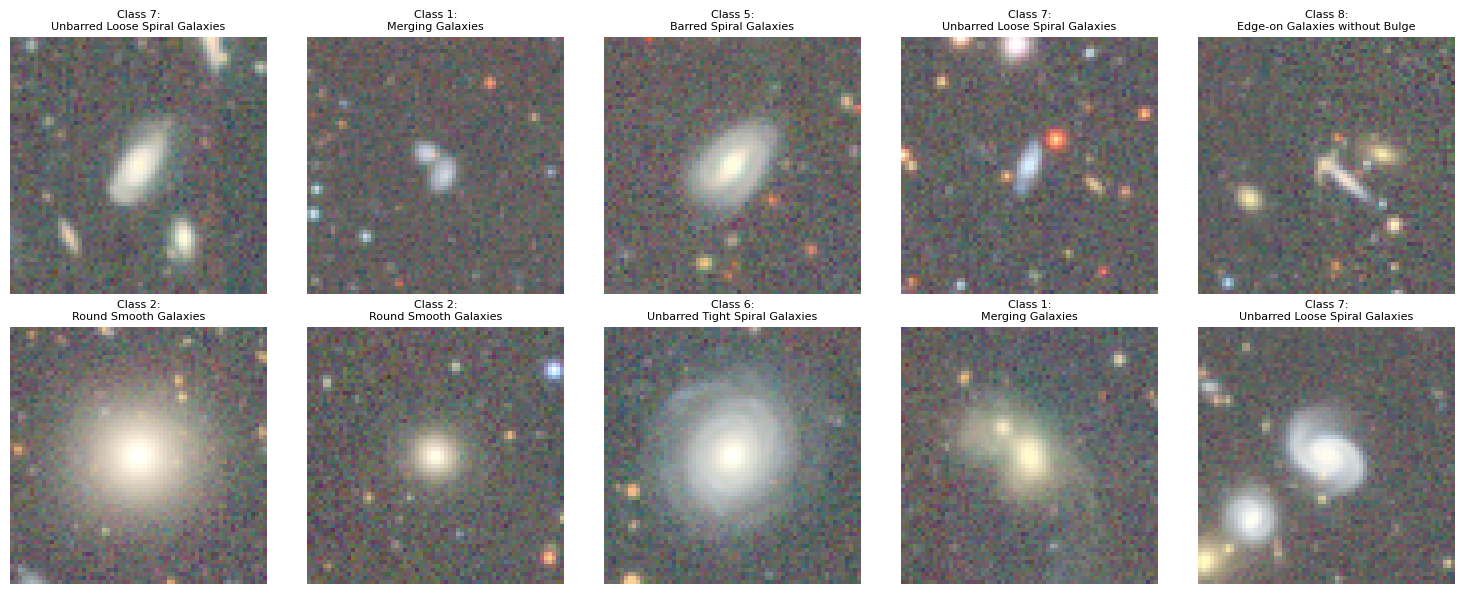

In [5]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)

def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [6]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [7]:
# For training, remap standard labels from {0,...,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [8]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)
del std_images, std_labels
# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


In [9]:
aug_train = data_augmentation(X_train_std, training=True).numpy()
X_train_std = np.concatenate([X_train_std, aug_train], axis=0)
y_train_std = np.concatenate([y_train_std, y_train_std], axis=0)

In [10]:
def build_autoencoder(input_shape=(64, 64, 3), latent_dim=32):
    inputs = Input(shape=input_shape)

    ####### ENCODER #######
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = ReLU()(x)

    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = ReLU()(x)

    ####### LATENT SPACE #######
    x = Flatten()(x)
    x = Dense(latent_dim)(x)

    ####### DECODER #######
    x = Dense(4*4*256)(x)
    x = Reshape((4,4,256))(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D()(x)
    outputs = Conv2D(3, 3, padding='same', activation='sigmoid')(x)

    return Model(inputs, outputs)

In [11]:
latent_dim = 32
# Build the autoencoder model
autoencoder = build_autoencoder(latent_dim=latent_dim)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           12

 Total params: 1,043,747 (3.98 MB)

 Trainable params: 1,043,299 (3.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

# Train the autoencoder on the training data
history = autoencoder.fit(X_train_std, X_train_std,
                          epochs=20,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_val_std, X_val_std),
                          callbacks=[early_stopping])


Epoch 1/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 2/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 3/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 4/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 5/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 6/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 7/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 9/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 11/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 12/20
521/521 ━━━━━━━━━━━━━━━━━━━━

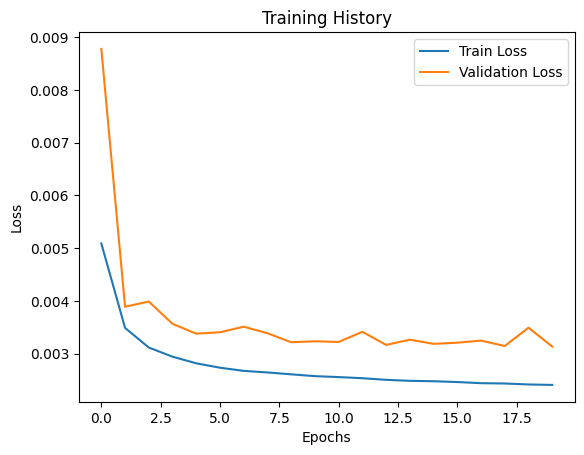

In [13]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Create new test set with anomalies
x_test = np.concatenate([X_test_std, anom_images], axis=0)
y_test = np.concatenate([np.zeros(len(X_test_std)), np.ones(len(anom_images))], axis=0)

# Compute reconstruction MSE for normal and anomaly images
x_out_test = autoencoder.predict(x_test)
mse_test = np.mean(np.square(x_out_test - x_test), axis=(1,2,3))

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


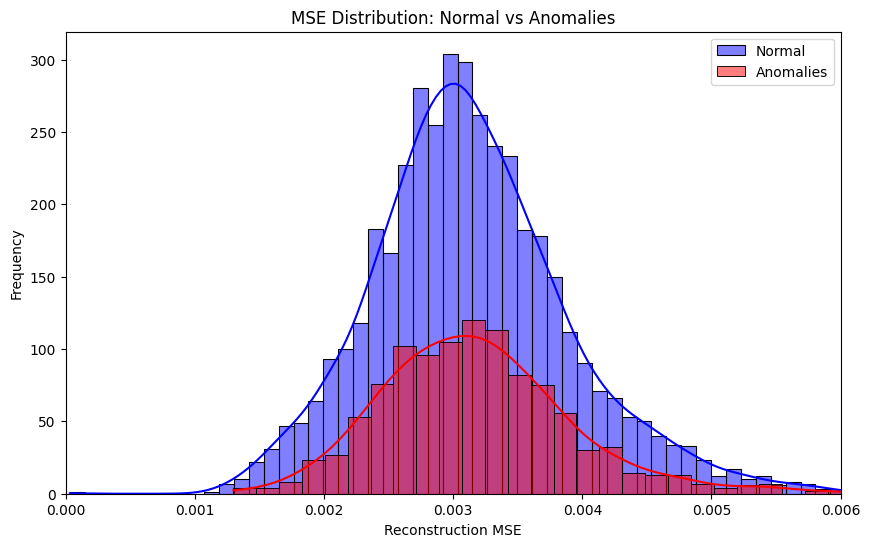

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(mse_test[y_test == 0], label='Normal', color='blue', kde=True)
sns.histplot(mse_test[y_test == 1], label='Anomalies', color='red', kde=True)
plt.xlim(0, 0.006)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.xlabel('Reconstruction MSE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

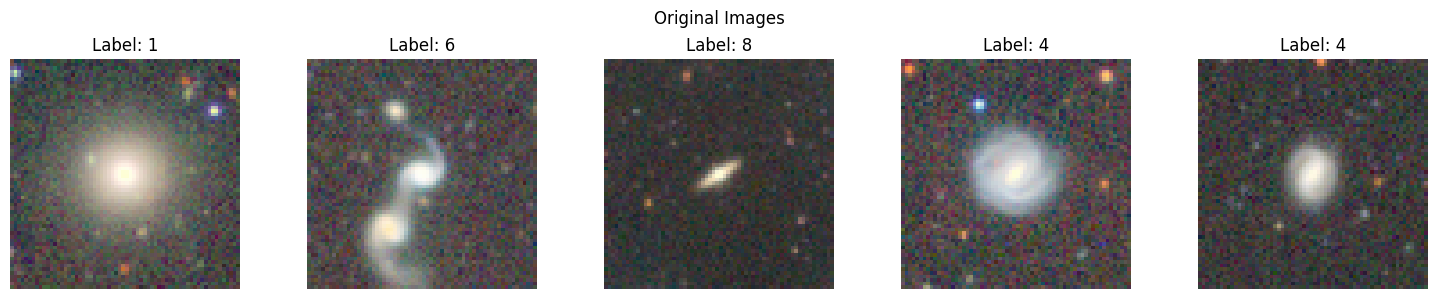

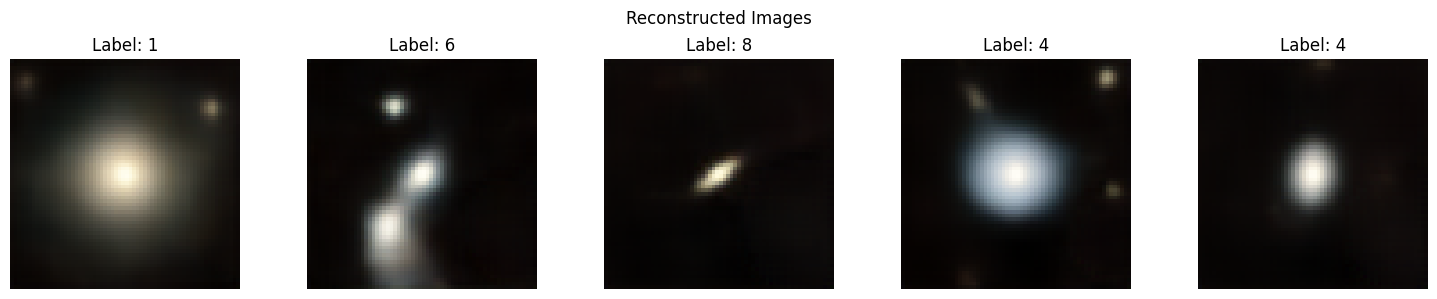

In [29]:
def show_images(images, labels=None, n=5, title="Images"):
    """
    Plot the first n images, rescaling them to [0,1] for proper display.
    Works for RGB images that were arcsinh-normalized.
    """
    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for i in range(n):
        ax = axes[i]
        img = images[i]

        # Rescale per image for display
        img_min, img_max = img.min(), img.max()
        img_disp = (img - img_min) / (img_max - img_min + 1e-8)

        ax.imshow(img_disp)
        if labels is not None:
            ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


show_images(x_test, labels=y_test_std, n=5, title="Original Images")
show_images(x_out_test, labels=y_test_std, n=5, title="Reconstructed Images")

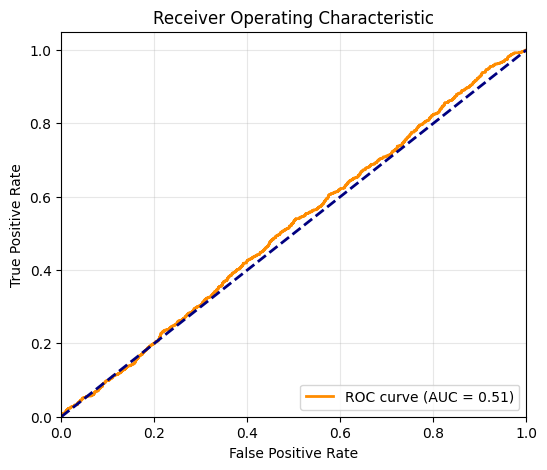

In [17]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, mse_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()